# 🌾 Crop Production Prediction — End-to-End ML Pipeline

**Goal:** Predict agricultural **Production** from climate & historical features using a clean, reproducible ML workflow.

**What this notebook covers:**
1. Data loading & sanity checks  
2. Exploratory Data Analysis (EDA) with visuals  
3. Preprocessing: numeric scaling + categorical one-hot encoding  
4. Model training (Linear Regression, Random Forest, Gradient Boosting)  
5. Evaluation (MAE, RMSE, R²) + model selection  
6. Export the best model to `crop_model.pkl` (for Flask deployment)


In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

plt.rcParams['figure.figsize'] = (8, 4)  # one chart per cell; no seaborn


In [2]:
pip install --upgrade scikit-learn


In [3]:
# Place crop_production.csv in the same folder as this notebook
df = pd.read_csv("crop_production.csv")
assert "Production" in df.columns, "The dataset must contain a 'Production' column."
df.head()


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


In [4]:
print("Shape:", df.shape)
display(df.describe(include='all').T)
print("\nMissing per column:")
print(df.isna().sum().sort_values(ascending=False))


Shape: (246091, 7)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State_Name,246091,33,Uttar Pradesh,33306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
District_Name,246091,646,BIJAPUR,945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Crop_Year,246091.0,NaN,NaN,NaN,2005.643018,4.952164,1997.0,2002.0,2006.0,2010.0,2015.0
Season,246091,6,Kharif,95951,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Crop,246091,124,Rice,15104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area,246091.0,NaN,NaN,NaN,12002.820864,50523.404019,0.04,80.0,582.0,4392.0,8580100.0
Production,242361.0,NaN,NaN,NaN,582503.442251,17065813.17241,0.0,88.0,729.0,7023.0,1250800000.0



Missing per column:
Production       3730
District_Name       0
State_Name          0
Crop_Year           0
Season              0
Crop                0
Area                0
dtype: int64


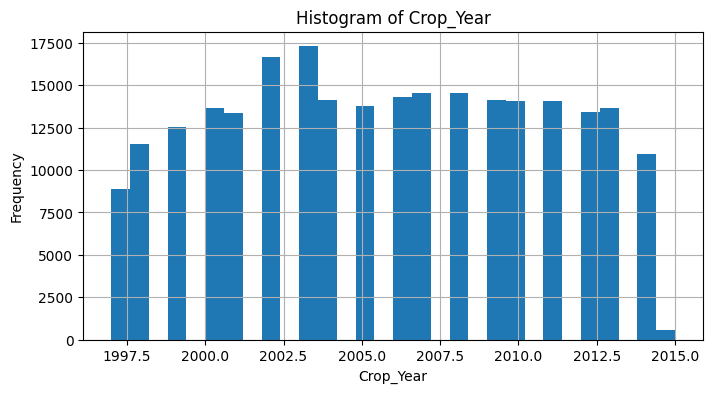

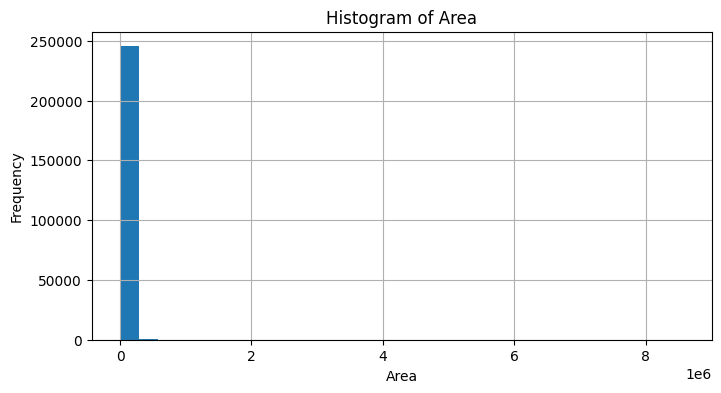

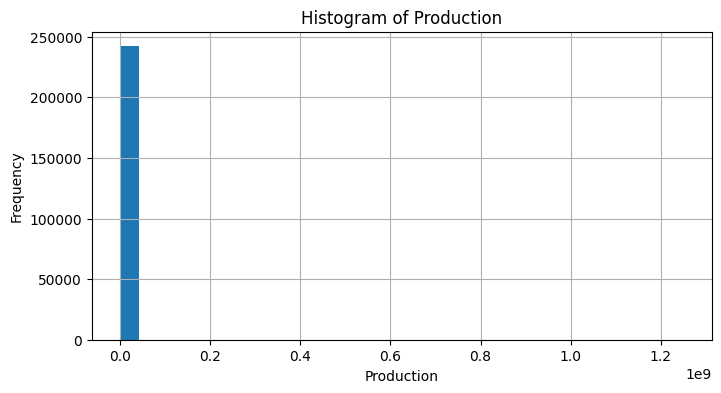

In [5]:
# Histograms for up to 6 numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols[:6]:
    df[col].hist(bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col); plt.ylabel("Frequency"); plt.show()


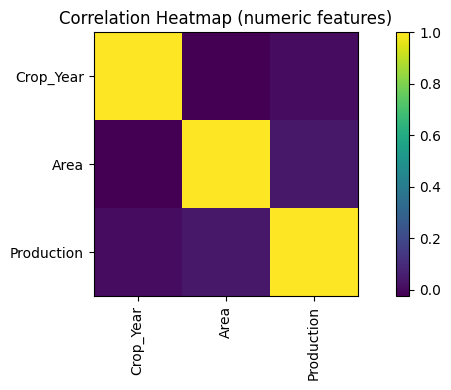

In [6]:
# Correlation heatmap (numeric only)
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    corr = num_df.corr()
    plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation Heatmap (numeric features)")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.tight_layout(); plt.show()


In [7]:
target_col = "Production"

X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# drop rows with missing target
mask_valid = ~y.isna()
X = X.loc[mask_valid].reset_index(drop=True)
y = y.loc[mask_valid].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in X_train.columns if c not in num_features]

numeric_transformer = Pipeline([('scaler', StandardScaler(with_mean=False))])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features),
])
num_features, cat_features


(['Crop_Year', 'Area'], ['State_Name', 'District_Name', 'Season', 'Crop'])

In [12]:
# ✅ Remove rows where Production is NaN
df = df.dropna(subset=["Production"]).reset_index(drop=True)

# ✅ Now sample for faster training
df_sample = df.sample(60000, random_state=42)
X_sample = df_sample.drop("Production", axis=1)
y_sample = df_sample["Production"]


X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# ✅ Step 2: Use simpler models (less trees for RandomForest)
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42, n_estimators=80)
}

results = []
best_name, best_pipe, best_rmse = None, None, float('inf')

for name, model in models.items():
    pipe = Pipeline([('preprocess', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    # ✅ RMSE: manually compute to avoid version issues
    rmse = mean_squared_error(y_test, preds) ** 0.5
    r2 = r2_score(y_test, preds)

    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    if rmse < best_rmse:
        best_rmse, best_pipe, best_name = rmse, pipe, name

import pandas as pd
results_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
results_df


,Model,MAE,RMSE,R2
0,RandomForest,2.265627e+05,1.005890e+07,0.707341
1,GradientBoosting,3.533902e+05,1.098384e+07,0.651045
2,LinearRegression,2.445348e+06,1.693045e+07,0.170918


In [13]:
import joblib

# ✅ Save the best model (RandomForest)
joblib.dump(best_pipe, "crop_model.pkl")
print("✅ Model saved as crop_model.pkl")


✅ Model saved as crop_model.pkl
